# Identifying Oscillations

This notebook will show how to quantify neural oscillations. Here, from some example data, we will calculate and plot:
1. Power spectrum
2. Windowed (classic) spectrogram
3. Wavelet based spectrogram

## Frequency Domain

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, spectrogram

In [2]:
#Load in the LFP, stimulation time data
fpath = (r'C:\Users\Michael\Documents\ephys_analysis_tutorials\\')
lfp_data = np.load(fpath+'example_lfp_160819_bank2.npy')
stim_times = np.load(fpath+'example_stim_times_160819_bank2.npy')
fs = 1000

Here, we have lfp data (already filtered + resampled to 1000Hz) from an electrode in the olfactory bulb, recording while odors are presented. The array stim_times indicates when odors are experienced (the first inhalation after each odor presentation), for 6 different odors, formatted as odors x events.

Text(0, 0.5, 'Voltage')

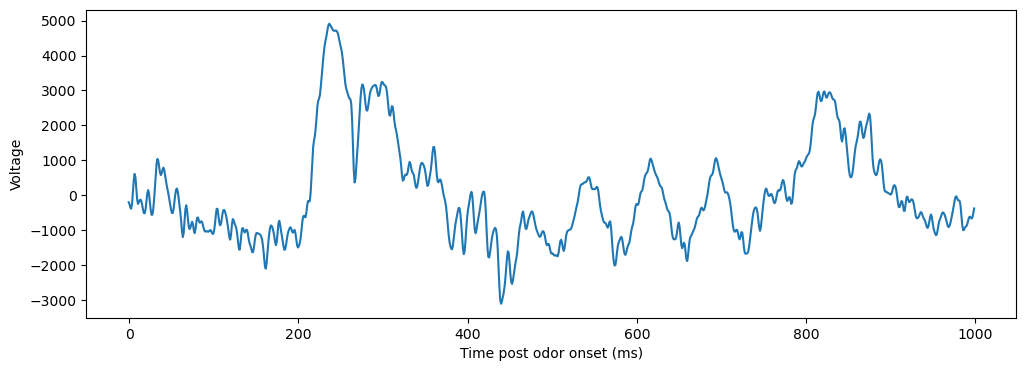

In [3]:
#Plot the lfp data in response to stimulation
evt = stim_times[0,7] #look at the first presentation of the first odor
time_segment = [int(evt*fs), int(evt*fs+1000)] #start and end event times of interest, converted to ms
plt.figure(figsize=(12,4))
plt.plot(np.arange(time_segment[0], time_segment[1], 1)-evt*fs, lfp_data[time_segment[0]:time_segment[1]])
plt.xlabel('Time post odor onset (ms)')
plt.ylabel('Voltage')

We see a big deflection around 200ms, and an oscillation until a little after 600ms. Next, we'll want to quantify the presence of this oscillation. A common first step here is to plot the power spectrum of the data.

### Power Spectrum
Using a Fourier transformation, any signal can be decomposed into some combination of sinusoidal oscillations. The power spectrum of a signal describes the distribution of frequency components that compose that signal. It is often used to quantify the presence of different oscillations, as a power spectrum quantifies the amplitude across frequencies. 

More specifically, to compute a power spectrum, the autocorrelation of a signal is computed, and then the Fourier Transform of the result is taken. Though this can be computed once, across the entire signal, in practice this results in a noisy estimate of the power spectrum. Here, we'll use Welch's method [[1]](#References) to compute power, where the signal is segmented into a series of overlapping windows, and the power spectrum of each segment are averaged. The window size and overlap are determined by the *nperseg* and *noverlap* parameters in scipy's welch function. Feel free to mess around with these to get an idea of the tradeoffs between large and small windows, and the degree of overlap.

Text(0, 0.5, 'Power Spectral Density')

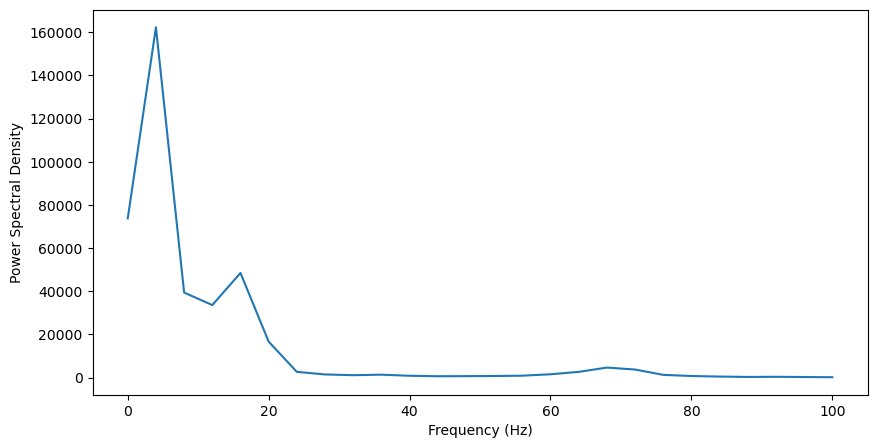

In [4]:
f, Pxx = welch(lfp_data[time_segment[0]:time_segment[1]], fs=fs, nperseg=250, noverlap=100)
f = f[np.where(f<=100)] #select only frequencies below 100Hz
Pxx = Pxx[np.where(f<=100)]
plt.figure(figsize=(10,5))
plt.plot(f, Pxx)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')

The power spectrum is much higher at lower frequencies (<20Hz). This is characteristic of neural LFP data, referred to as 1/f or pink noise, where power systematically decreases with frequency. Still, we can see three peaks in power that go beyond this trend: one around 5Hz, one just below 20Hz, and another small peak around 70Hz. To better visualize this, we should remove the 1/f noise in the data. Though an [excellent tool](https://fooof-tools.github.io/fooof/index.html) has been developed for this purpose, we can also remove this noise by normalizing to a baseline period, before odor presentation, where this noise will still be present. This will also help us identify which oscillations are specifically induced by the odor.

To do so, we'll take the power spectrum for 1 second of data before the odor was presented, and divide the odor-evoked psd by this baseline psd. **Note**: Make sure your parameters match the ones you used to compute the first power spectrum, or else the frequency resolution won't match and you won't be able to normalize.

Text(0, 0.5, 'Power Spectral Density')

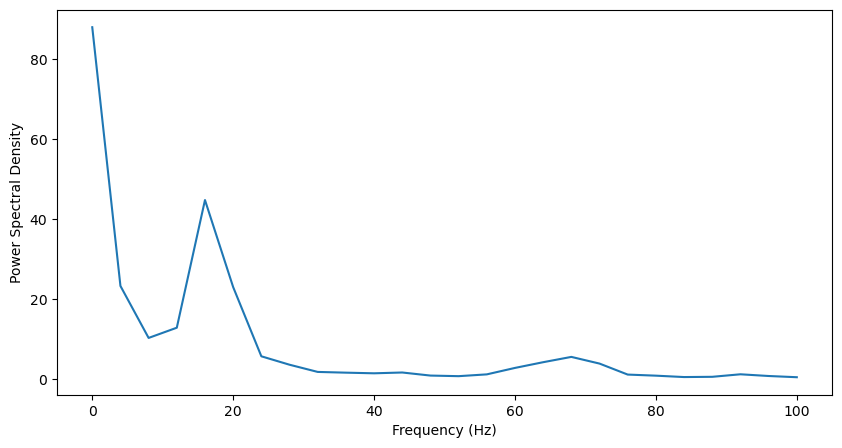

In [5]:
Pxx_evoked = Pxx
time_segment = [int(evt*fs)-1000, int(evt*fs)] #start and end event times of interest, converted to ms
f, Pxx_baseline = welch(lfp_data[time_segment[0]:time_segment[1]], fs=fs, nperseg=250, noverlap=100)
f = f[np.where(f<=100)] #select only frequencies below 100Hz
Pxx_baseline = Pxx_baseline[np.where(f<=100)]
Pxx_normalized = Pxx_evoked / Pxx_baseline
plt.figure(figsize=(10,5))
plt.plot(f, Pxx_normalized)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')

That helps a little bit: we now clearly see the peak in beta (\~20Hz). There's also a big increase in power at the lowest frequencies.

A power spectra is a useful first step for examining the oscillatory content of a time-series. However, we are still missing 
some information. For example, here, the gamma (\~70Hz) oscillation is pretty muted. One reason for this is the gamma oscillation is brief, and here we're looking at power over the entire second, making it hard to distinguish between a brief oscillation from a weak one. To better analyze this, let's look at how power changes over time.

## Time Frequency Domains

Time frequency analyses, as the name indicates, introduce a time dimension to our power analyses. This allows us to analyze when exactly oscillations are present. Now, our outputs are matrices called spectrograms, plotted as heatmaps, of power over both frequency and time.

### Window analysis

A simple and common time frequency analysis is to compute a spectrogram as a series of power spectra. Here, the data is broken up into a set of overlapping windows, and the power spectrum is computed on each of these windows. We can use scipy's spectrogram function here.

Text(0, 0.5, 'Frequency (Hz)')

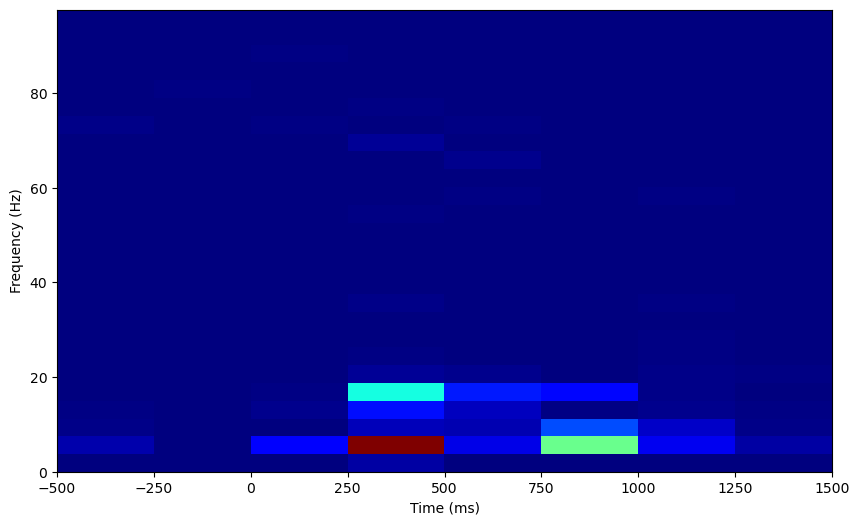

In [6]:
relative_times = [-500,1500]
time_segment = [int(evt*fs)+relative_times[0], int(evt*fs+relative_times[1])] #start and end event times of interest, converted to ms
f, t, Sxx = spectrogram(lfp_data[time_segment[0]:time_segment[1]], fs)
f = f[np.where(f<=100)] #select only frequencies below 100Hz
Sxx = Sxx[np.where(f<=100)[0],:] #select only frequencies below 100Hz
plt.figure(figsize=(10,6))
plt.imshow(Sxx, extent=[relative_times[0], relative_times[-1], f[0], f[-1]], aspect = 'auto', origin = 'lower', cmap='jet')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')

Let's normalize this too. Now that we have data on how our power changes over time, we get multiple samples of power data for each frequency, and we can z-score the evoked power to this distribution at baseline.

Text(0, 0.5, 'Frequency (Hz)')

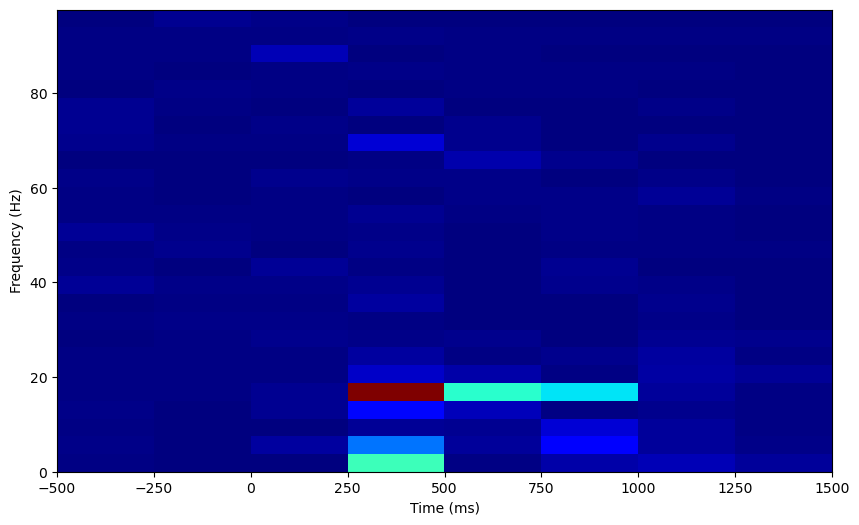

In [7]:
Sxx_evoked = Sxx
time_segment = [int(evt*fs)-2000, int(evt*fs)] #start and end event times of interest, converted to ms
f, t, Sxx_baseline = spectrogram(lfp_data[time_segment[0]:time_segment[1]], fs)
f = f[np.where(f<=100)] #select only frequencies below 100Hz
Sxx_baseline = Sxx_baseline[np.where(f<=100)[0],:] #select only frequencies below 100Hz

Sxx_normalized = np.empty(Sxx_evoked.shape)
for f_i in range(0, Sxx_evoked.shape[0]):
    Sxx_normalized[f_i, :] = (Sxx_evoked[f_i, :] - np.mean(Sxx_baseline[f_i, :])) / np.std(Sxx_baseline[f_i, :])
plt.figure(figsize=(10,6))
plt.imshow(Sxx_normalized, extent=[relative_times[0], relative_times[-1], f[0], f[-1]], aspect = 'auto', origin = 'lower', cmap='jet')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')

The output here is clearly very blocky, due to the windowing procedure. There's also a tradeoff between time resolution and frequency resolution we can explore. Here, the bigger the time window used, the finer the frequency resolution of each power spectrum, and therefore the spectrogram as a whole. However, bigger time windows decrease time resolution as well, so we can optimize the time resolution by choosing to use smaller time windows. In scipy's spectrogram function, the length of the time segments are set by the nperseg argument, indicating the number of samples per segment. Let's try optimizing for time or frequency resolution.

Text(0.5, 1.0, 'Increased frequency resolution')

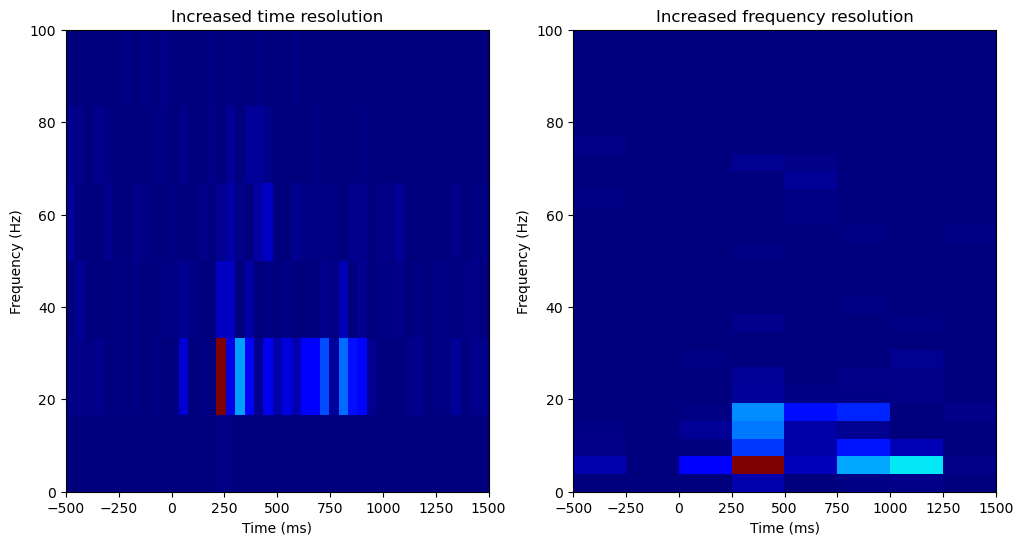

In [8]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
time_segment = [int(evt*fs)-500, int(evt*fs)+1500] #start and end event times of interest, converted to ms
f, t, Sxx = spectrogram(lfp_data[time_segment[0]:time_segment[1]], fs, nperseg=50)
f = f[np.where(f<=100)] #select only frequencies below 100Hz
Sxx = Sxx[np.where(f<=100)[0],:] #select only frequencies below 100Hz
plt.imshow(Sxx, extent=[relative_times[0], relative_times[-1], f[0], f[-1]], aspect = 'auto', origin = 'lower', cmap='jet')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')
plt.title('Increased time resolution')

plt.subplot(1,2,2)
f, t, Sxx = spectrogram(lfp_data[time_segment[0]:time_segment[1]], fs, nperseg=250)
f = f[np.where(f<=100)] #select only frequencies below 100Hz
Sxx = Sxx[np.where(f<=100)[0],:] #select only frequencies below 100Hz
plt.imshow(Sxx, extent=[relative_times[0], relative_times[-1], f[0], f[-1]], aspect = 'auto', origin = 'lower', cmap='jet')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')
plt.title('Increased frequency resolution')

Increasing the frequency resolution, we can see power is increasing in two distinct lower frequency bands, one around 4Hz and another around 20Hz. 

Overall, a window-based spectrogram is a straightforward way to extract oscillatory power over both time and frequency. However, the outputs here are very limited in both time and frequency resolution. When analyzing oscillations over long (>10s) timescales, this is not a problem, and the results will look much better than these. However, we want to analyze oscillation power over a small time window (~1s), and so currently our time and frequency resolution is poor. To better analyze oscillation power in the time and frequency domains for this short time period, a morlet wavelet based analysis is more effective.

### Morlet wavelets

An alternative to a windowed fourier analysis is convolution with morlet (or Gabort) wavelets. These wavelets are themselves sinewaves weighted by a gaussian. This weighting provides temporal specificity, and convolving these wavelets with the signal allows for the measurement of power over time. To analyze power from different frequencies, wavelets are created from sinewaves of different frequencies. Spectrograms produced from morelet wavelet analysis are not "blocky" like the fourier analysis, as the gaussian weighting of the wavelets results in a gaussian spread of power over both time and frequency. 

Fewer packages support morlet wavelet convolution. [MNE](https://mne.tools/stable/index.html) is an has a [great function for this](https://mne.tools/stable/generated/mne.time_frequency.tfr_morlet.html) we'll use here. The package is a great resource for analyzing LFP data in python, though it is designed for EEG+MEG data. 

First, let's set up or data for mne. We need to create an info structure, and format the data into an epochs array.

In [9]:
import mne

In [10]:
info = mne.create_info(ch_names=list(map(str, np.arange(1, 2, 1))), sfreq=fs, ch_types=['eeg'])
epoch = np.empty((1, 1, len(np.arange(time_segment[0], time_segment[1],1))))
epoch[0,0,:] = lfp_data[time_segment[0]:time_segment[1]] #Format data into [epochs, channels, samples] format
epoch = mne.EpochsArray(epoch, info, verbose=False)

When we run the morlet time-frequency analysis, we'll need to set a the parameter n_cycles. Like fourier window analyses, morelet wavelet analyses have inputs that result in a trade-off between time and frequency resolution, namely, the length of the wavelet. Longer wavelets are less precise in time, but more precise in frequency. In MNE, the length of the wavelet is determined by the n_cycles parameter, which indicates the number of cycles in the wavelets (with frequency held constant, such that more cycles results in a longer wavelet). This can be set globally for all wavelets, resulting in the same frequency specificity across wavelets of different frequencies. Let's try this first.





Text(0, 0.5, 'Frequency (Hz)')

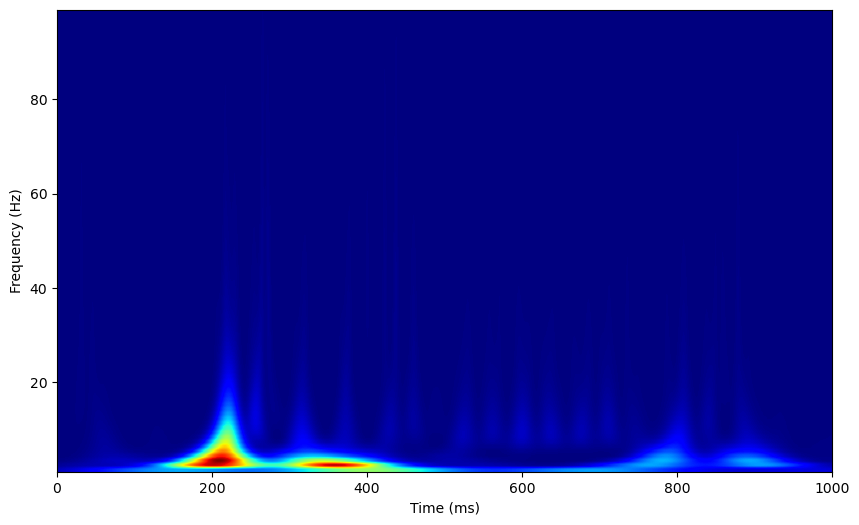

In [11]:
freqs = np.arange(1,100)
tf_pow = mne.time_frequency.tfr_morlet(epoch, freqs=freqs, n_cycles=1, return_itc=False, average=False, verbose=False)
tf_pow.data = np.squeeze(tf_pow.data)
plt.figure(figsize=(10,6))
plt.imshow(tf_pow.data, extent=[relative_times[0], relative_times[1], tf_pow.freqs[0], tf_pow.freqs[-1]],
           aspect = 'auto', origin = 'lower', cmap='jet')
plt.xlim([0, 1000])
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')

Again, we can normalize by a baseline period. MNE has an apply_baseline function on time_frequency objects we can use to here, we just need to compute the spectrogram over both the baseline and evoked periods to give the function all the data it needs.

Applying baseline correction (mode: zscore)


(0.0, 1000.0)

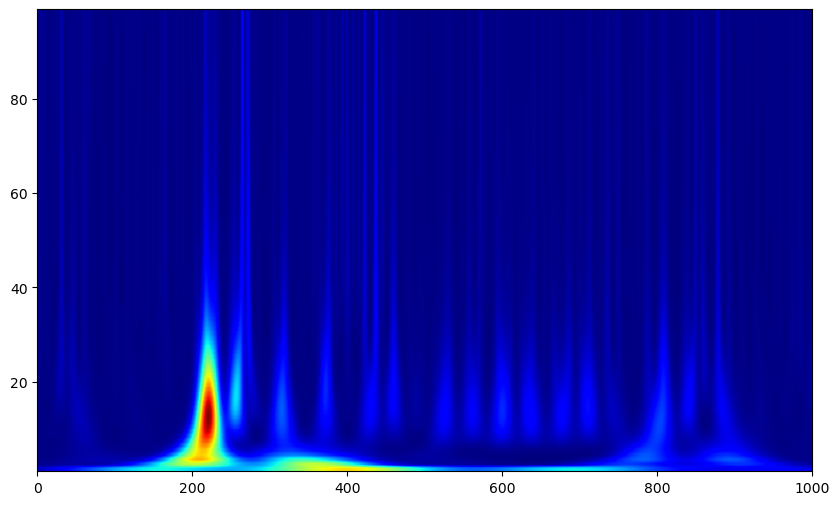

In [12]:
relative_times = [-2000,1500]
time_segment = [int(evt*fs)+relative_times[0], int(evt*fs)+relative_times[1]] #start and end event times of interest, converted to ms
epoch = np.empty((1, 1, len(np.arange(time_segment[0], time_segment[1],1))))
epoch[0,0,:] = lfp_data[time_segment[0]:time_segment[1]] #Format data into [epochs, channels, samples] format
epoch = mne.EpochsArray(epoch, info, verbose=False)
freqs = np.arange(1,100)
tf_pow = mne.time_frequency.tfr_morlet(epoch, freqs=freqs, n_cycles=1, return_itc=False, average=False, verbose=False)
tf_pow.apply_baseline(mode='zscore', baseline=(.2, 1.800)) #add a little padding for the baseline
tf_pow.data = np.squeeze(tf_pow.data)
plt.figure(figsize=(10,6))
plt.imshow(tf_pow.data, extent=[relative_times[0], relative_times[1], tf_pow.freqs[0], tf_pow.freqs[-1]],
           aspect = 'auto', origin = 'lower', cmap='jet')
plt.xlim([0, 1000])

This looks better, but this spectrogram still appears smeared over time at low frequencies while varying sharply at high frequencies. This is because when we set n_cycles globally, the time specificity of each wavelet will vary, as one cycle of a 2Hz oscillation takes much more time than one cycle of a 20Hz oscillation. Therefore, weighting the number of cycles of wavelets by their frequencies is often preferable.

Applying baseline correction (mode: zscore)


Text(0, 0.5, 'Frequency (Hz)')

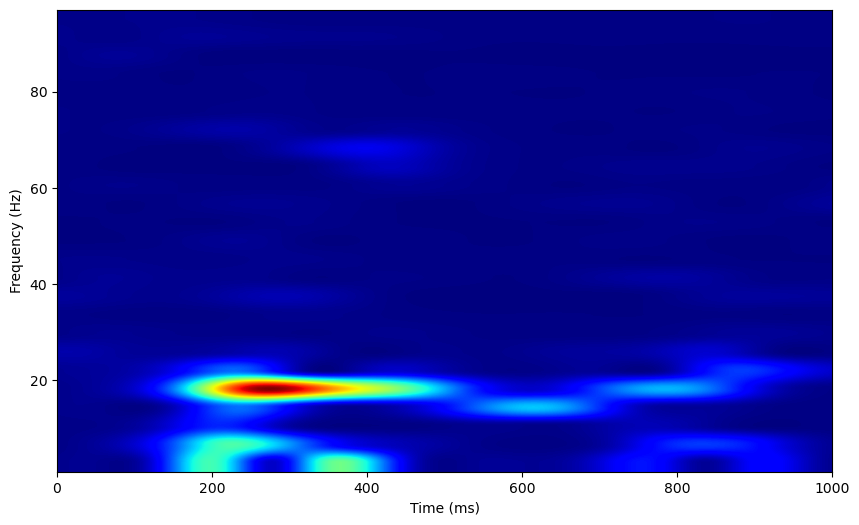

In [13]:
relative_times = [-2000,1500]
time_segment = [int(evt*fs)+relative_times[0], int(evt*fs)+relative_times[1]] #start and end event times of interest, converted to ms
epoch = np.empty((1, 1, len(np.arange(time_segment[0], time_segment[1],1))))
epoch[0,0,:] = lfp_data[time_segment[0]:time_segment[1]] #Format data into [epochs, channels, samples] format
epoch = mne.EpochsArray(epoch, info, verbose=False)
freqs = np.arange(1,100,4)
n_cycles = freqs / 2
tf_pow = mne.time_frequency.tfr_morlet(epoch, freqs=freqs, n_cycles=n_cycles, return_itc=False, average=False, verbose=False)
tf_pow.apply_baseline(mode='zscore', baseline=(.2, 1.800)) #add a little padding for the baseline
tf_pow.data = np.squeeze(tf_pow.data)
plt.figure(figsize=(10,6))
plt.imshow(tf_pow.data, extent=[relative_times[0], relative_times[1], tf_pow.freqs[0], tf_pow.freqs[-1]],
           aspect = 'auto', origin = 'lower', cmap='jet')
plt.xlim([0, 1000])
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')

Now, we can see a clear oscillation at 20Hz, and a weak oscillation around 70Hz, around 400ms post odor presentation.

Each of these analyses measures the power of sinusoidal oscillations. However, neural oscillations are often non-sinusoidal, and this can lead to some erroneous outputs. For example, a non-sinusoidal oscillation will often lead to spurious peaks in power at harmonic frequencies of the actual oscillation frequency. This occurs when the fourier analysis decomposes the non-sinusoidal oscillation into a sinusoidal oscillation at its true frequency, and resulting in leftover signal that can be composed from harmonics of that frequency [[2]](#References)

## References
1. P. Welch, “The use of the fast Fourier transform for the estimation of power spectra: A method based on time averaging over short, modified periodograms”, IEEE Trans. Audio Electroacoust. vol. 15, pp. 70-73, 1967.
2. Donoghue, T., Schaworonkow, N., & Voytek, | Bradley. (2021). Methodological considerations for studying neural oscillations. https://doi.org/10.1111/ejn.15361